In [1]:
from Obstacle import *
from Visualization import *
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from Utils.Node import *
import math
import queue
import random
import copy

wheel_radius = 0.038
wheel_distance = 0.354

In [2]:
def halfRound(n):
    return round(2*n)/2
def toRadian(angle):
    return np.pi * angle / 180
def toDegree(angle):
    return 180 * angle / np.pi

In [3]:
def visualize(viz, traversed_nodes, destination, goal_node, obs, show_pass):
    fig, ax = plt.subplots(figsize = (10, 10))
    ax.set(xlim=(0, 10), ylim = (0,10))
    ax = viz.addObstacles2Map(ax)
    ax.set_aspect("equal")
    c = 0
    print(len(traversed_nodes))
    if show_pass:
        for node in traversed_nodes:
            start_node  = node.getParent()
            if start_node is not None:
                xi, yi, _, _ = start_node.getState()
                points = node.getPathArray()
                if points is not None:
                    for point in points:
                        xn, yn = point
                        ax.plot([xi, xn], [yi, yn], color="blue", linewidth = 0.3)
                        xi, yi = xn, yn

    # i = 0
    # y = goal_node.getState()[1]
    # y_ = goal_node.getState()[1]
    # ax.scatter(goal_node.getState()[0], y)
    # theta = toRadian(goal_node.getState()[2])
    # while(i<10):
    #     if goal_node.getState()[2] % 90 == 0:
    #         x = goal_node.getState()[0]
    #     else:
    #         x = y/math.tan(theta)
    #     i+=1
    #     y+=0.1
    #     y_-=0.1
    #     ax.scatter(x,y)
    #     ax.scatter(x,y_)

    x, y = goal_node.getState()[:2]
    x_, y_ = goal_node.getState()[:2]
    theta = toRadian(goal_node.getState()[2])
    ax.scatter(x,y)
    d = 1
    x = x + d*math.cos(theta)
    y = y + d*math.sin(theta)
    x_ = x_ - d*math.cos(theta)
    y_ = y_ - d*math.sin(theta)
    ax.plot([x, x_], [y, y_], color="red", linewidth = 5)


    current_node = copy.copy(destination)
    nodes = []
    while(current_node.getParent() is not None):
        nodes.append(current_node)
        current_node = current_node.getParent()
    nodes.append(current_node)
    nodes.reverse()

    for node in nodes:
        start_node  = node.getParent()
        
        if start_node is not None:
            xi, yi, _, _ = start_node.getState()
            points = node.getPathArray()
            if points is not None:
                for point in points:
                    xn, yn = point[:2]                  
                    ax.plot([xi, xn], [yi, yn], color="green", linewidth = 2)
                    xi, yi = xn, yn
    a = str(random.randint(1,1000))
    plt.savefig(a + '.png')
    return nodes


In [4]:
def getBranches(node, T, u_linear, u_steer1, u_steer2, obs):
    actions=[[u_linear, 0], [u_linear, u_steer1], [u_linear, -u_steer1], [u_linear, u_steer2], [u_linear, -u_steer2],[-u_linear, 0], [-u_linear, u_steer1], [-u_linear, -u_steer1], [-u_linear, u_steer2], [-u_linear, -u_steer2]]
    state = node.getState()
    branches = []

    for action in actions:
        new_state, path_array, cost = move(state, action, T, obs)
        if new_state is not None:
            branch_node = Node(new_state, node, action, node.getCost() + cost, path_array)
            branches.append(branch_node)
              
    return branches

In [5]:
def isOnSpot(current, final):
    x_current, y_current, theta_current = current.getState()[:3]
    x_goal, y_goal, theta_goal = final.getState()[:3]

    theta_goal = toRadian(theta_goal)
    theta_current = toRadian(theta_current)
    
    m  = math.tan(theta_goal)
    if abs(theta_goal) == 90 or abs(theta_goal) == 270:
        c = 0
    else:
        c = y_goal - x_goal*m
    error = y_current - x_current*math.tan(theta_goal) - c

    if (abs(theta_goal) > 265 and abs(theta_goal) < 275) or (abs(theta_goal) > 85 and abs(theta_goal) < 95):
        error = x_current - x_goal
    d, _ = calculate_d_and_theta(current.getState(), final.getState())
    # print(d)
    # print(error)
    # print(_)
    return (abs(error) < 0.5 and d < 0.5)

In [6]:
def move(state, action, T, obs):
    t = 0
    dt = 0.1
    
    Xi, Yi, thetai, steeri = state
    thetai = toRadian(thetai)
    steeri = toRadian(steeri)

    u_linear, u_steer = action 

    Xn = Xi
    Yn = Yi
    thetan = thetai
    steern = steeri

    path_array = []
    cost = 0.0
    path_array.append([Xn, Yn])
    a = 1
    while t<T:
        t = t + dt
        steern += dt * u_steer
        if steern > np.pi / 4:
            steern = np.pi / 4
        if steern < -np.pi / 4:
            steern = -np.pi / 4

        thetan += (np.tan(steern) / a ) * u_linear * dt
        dx = u_linear * math.cos(thetan) * dt
        dy = u_linear * math.sin(thetan) * dt

        Xn += dx
        Yn += dy

        cost += math.sqrt(math.pow(dx,2) + math.pow(dy,2))
        path_array.append([Xn, Yn])

        if obs.isInObstacleSpace(Xn, Yn):
            return None, None, None
        
    thetan = int(toDegree(thetan))
    steern = int(toDegree(steern))
    return [Xn, Yn, thetan, steern] , path_array, cost

In [7]:
def getRandomNode():
    a = random.uniform(-np.pi, np.pi)
    # print(a)
    state = [random.uniform(0, 9), random.uniform(0,9), random.uniform(0, 360), 0]
    return Node(state, None, None, None, None)

def getNearestNodeIndex(node_list, random_point):
    distance = []
    # print(random_point)
    for node in node_list:
        node_pts = node.getState()
        alpha = 0.2
        d = (((node_pts[0] - random_point[0])**2 + (node_pts[1] - random_point[1])**2) + alpha *(np.abs(node_pts[2] - random_point[2]))) ** 0.5
        distance.append(d)
    min_idx = distance.index(min(distance))

    return min_idx

def calculate_d_and_theta(start, end):
    dx = end[0]- start[0]
    dy = end[1] - start[1]
    d = math.hypot(dx, dy)
    theta = math.atan2(dy, dx)
    return d, theta 

def getNewNode(nearest_node, random_point, obs):
    T = 1
    u_linear = 1
    u_steer1 = 0.2
    u_steer2 = 0.5
    sample_distance = 0.25

    nearest_point = nearest_node.getState()

    if obs.isInObstacleSpace(nearest_point[0], nearest_point[1]):
        print('Nearest point in OBSTACLE SPACE')
    
    _, theta = calculate_d_and_theta(nearest_point, random_point)
    ref_state = [sample_distance*math.cos(theta), sample_distance*math.sin(theta), random_point[2], 0]

    branches = getBranches(nearest_node, T, u_linear, u_steer1, u_steer2, obs)
    if (len(branches) > 0):
        branch_idx = getNearestNodeIndex(branches, ref_state)
        new_node = branches[branch_idx]
    else:
        new_node = None

    return new_node


In [8]:
def swap(a, b):
    temp = b.copy()
    b = a.copy()
    a = temp
    return a, b

In [9]:
def isConnected(node_list, node):
    min_p = 0.1
    min_a = 3
    connecting_distance = min_p + min_a
    connecting_node = None
    n_pts1 = node.getState()

    for n2 in node_list:
        n_pts2 = n2.getState()
        d_p = np.sqrt((n_pts2[0] - n_pts1[0])**2 + (n_pts2[1] - n_pts1[1])**2)
        d_a = np.abs(n_pts2[2] - n_pts1[2])

        if (d_p < min_p) & (d_a < min_a):
            min_p = d_p
            min_a = d_a
            connecting_distance = d_p + d_a
            connecting_node = n2

    return connecting_node, connecting_distance


In [10]:
def connectPath(node_list, node_from_list, node_b):
    path1 = []
    path2 = []

    n1 = node_from_list
    n2 = node_b
    n2.state = node_from_list.getState()

    path1.append(n1)
    while(n1.getParent() is not None):
        n1 = n1.getParent()
        path1.append(n1)

    # n2.state = [0,0,0,0]
    path2.append(n2)
    while(n2.getParent() is not None):
        n2 = n2.getParent()
        path2.append(n2)

    return path1, path2




In [11]:
def checkTreeIntersection(node_list, obs):
    node_list_filtered = []
    for node in node_list:
        intersection = False
        points = node.getPathArray()

        for point in points:
            if isInObstacleSpace(point[0], point[1]):
                intersection = True
                break

        if not intersection:
            node_list_filtered.append(node)
        return node_list_filtered



In [17]:
height, width = 10, 10
T = 1
dt = 0.1
threshold = 0.5
rand_map = [width-1, height-1]
start_point = [8,2,90,0]
goal_state = [2,4,90,0]
obs = Obstacle(0.1)
viz = Visualization(obs)

node_array = np.array([[[math.inf for k in range(360)] for j in range(int(height/threshold))] for i in range(int(width/threshold))])

goal_reached = False
start_node = Node(start_point, None, None, 0, [])
goal_node = Node(goal_state, None, None, math.inf, [])
final_node = None
node_list_s = [start_node]
node_list_g = [goal_node]
goal_node_final = None
destination = None

connected_node_list = []
connecting_dist = 100

obs_iter = 200
dynamic_obs_added = False


###########################for vizulization#####################

################################################################

for i in range(1000):
    ######################### add dynamic obstacle ##################################
    if i == obs_iter:
        # add obs
        obs.addNewObstacle(4, 4, 0.5, 0.5)
        dynamic_obs_added =  True

    if dynamic_obs_added:
        #check for intersection for tree 1 and tree 2
        if len(node_list_s) > 0:
            node_list_s = checkTreeIntersection(node_list_s, obs)
        if len(node_list_g) > 0:
            node_list_g = checkTreeIntersection(node_list_g, obs)
        dynamic_obs_added = False

    ################################################################################
    random_node = getRandomNode()
    nearest_idx = getNearestNodeIndex(node_list_s, random_node.getState())
    nearest_node = node_list_s[nearest_idx]
    new_node_s = getNewNode(nearest_node, random_node.getState(), obs)
    if (new_node_s == None):
        continue

    if new_node_s is not None:

        node_list_s.append(new_node_s)
        nearest_idx = getNearestNodeIndex(node_list_g, new_node_s.getState())
        nearest_node = node_list_g[nearest_idx]
        new_node_g = getNewNode(nearest_node, new_node_s.getState(), obs)
        if new_node_g is not None:
            connecting_node_g, connecting_dist_g = isConnected(node_list_g, new_node_s)
            connecting_node_s, connecting_dist_s= isConnected(node_list_s, new_node_g)

            if (connecting_node_g is not None):
                print("Connected node found g!")
                connected_node_list.append(connecting_node_g.getState()) 
                if connecting_dist_g < connecting_dist:
                    connecting_dist = connecting_dist_g
                    p1, p2 = connectPath(node_list_g, connecting_node_g, new_node_s)

            if(connecting_node_s is not None):
                print("Connected node found s!")
                connected_node_list.append(connecting_node_s.getState())
                if connecting_dist_s < connecting_dist:
                    connecting_dist = connecting_dist_s
                    p1, p2 = connectPath(node_list_s, connecting_node_s, new_node_g)

            node_list_g.append(new_node_g)
            node_list_s, node_list_g = swap(node_list_s, node_list_g)

Connected node found s!
Connected node found s!
Connected node found s!
Connected node found g!
Connected node found s!
Connected node found s!
Connected node found s!
Connected node found s!
Connected node found s!
Connected node found g!
Connected node found s!
Connected node found s!
Connected node found s!
Connected node found s!
Connected node found s!
Connected node found s!
Connected node found s!
Connected node found g!
Connected node found s!
Connected node found s!
Connected node found s!
Connected node found s!
Connected node found s!
Connected node found s!
Connected node found g!
Connected node found g!
Connected node found s!
Connected node found s!
Connected node found s!
Connected node found s!
Connected node found s!
Connected node found g!
Connected node found s!
Connected node found s!
Connected node found s!
Connected node found s!
Connected node found s!
Connected node found g!
Connected node found s!
Connected node found g!
Connected node found s!
Connected node f

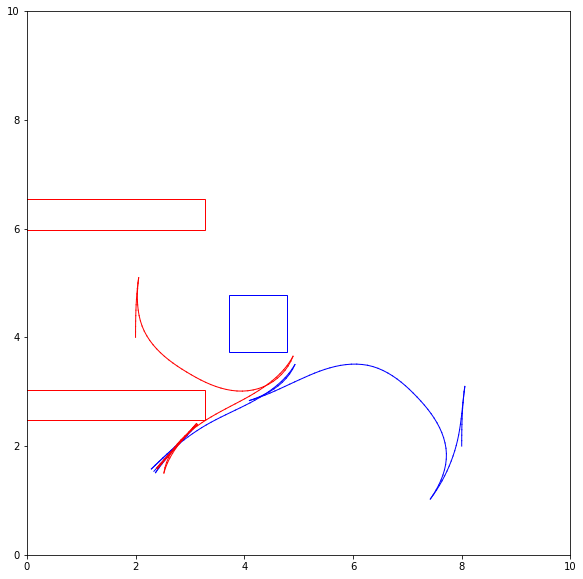

In [18]:
fig, ax = plt.subplots(figsize = (10, 10))
ax.set(xlim=(0, 10), ylim = (0,10))
ax = viz.addObstacles2Map(ax)
ax.set_aspect("equal")
c = 0

for node in p1:
    start_node  = node.getParent()
    if start_node is not None:
        xi, yi, _, _ = start_node.getState()
        points = node.getPathArray()
        if points is not None:
            for point in points:
                xn, yn = point
                ax.plot([xi, xn], [yi, yn], color="blue", linewidth = 1)
                xi, yi = xn, yn

for node in p2:
    start_node  = node.getParent()
    if start_node is not None:
        xi, yi, _, _ = start_node.getState()
        points = node.getPathArray()
        if points is not None:
            for point in points:
                xn, yn = point
                ax.plot([xi, xn], [yi, yn], color="red", linewidth = 1)
                xi, yi = xn, yn